# Setup

In [64]:
import numpy as np
import torch, os, cv2
import matplotlib.pyplot as plt
from PIL import Image as PILImage
from IPython.display import Image, display

In [3]:
imgs_path = "/dataset/images"
masks_path = "/dataset/masks"

# Dataset

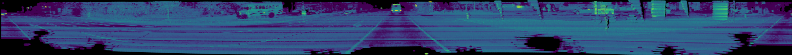

In [65]:
img_number = "/000001.png"
img_path = imgs_path + img_number
mask_path = masks_path + img_number

display(Image(filename=img_path))

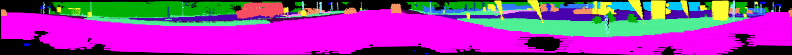

In [66]:
display(Image(filename=mask_path))

In [67]:
img = PILImage.open(img_path)
width, height = img.size
width, height

(792, 55)

# Configs

In [8]:
import torch
from torch.utils.data import Dataset

In [9]:
# base path of the dataset
DATASET_PATH = "mypath"
# define the path to the images and masks dataset
IMAGE_DATASET_PATH = os.path.join(DATASET_PATH, imgs_path)
MASK_DATASET_PATH = os.path.join(DATASET_PATH, masks_path)
# define the test split
TEST_SPLIT = 0.25
# determine the device to be used for training and evaluation
DEVICE = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {DEVICE} device")
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

Using cuda device


In [10]:
# define the number of channels in the input, number of classes,
# and number of levels in the U-Net model
NUM_CHANNELS = 1
NUM_CLASSES = 1
NUM_LEVELS = 3
# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 0.001
NUM_EPOCHS = 40
BATCH_SIZE = 16
# define the input image dimensions
INPUT_IMAGE_WIDTH = 792
INPUT_IMAGE_HEIGHT = 55
# define threshold to filter weak predictions
THRESHOLD = 0.5
# define the path to the base output directory
BASE_OUTPUT = "output"
# define the path to the output serialized model, model training
# plot, and testing image paths
MODEL_PATH = "unet_tgs_salt.pth"
PLOT_PATH = "plot.png"
TEST_PATHS = "test_paths.txt"

In [11]:
class SegmentationDataset(Dataset):
	def __init__(self, imagePaths, maskPaths, transforms):
		# store the image and mask filepaths, and augmentation
		# transforms
		self.imagePaths = imagePaths
		self.maskPaths = maskPaths
		self.transforms = transforms
	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.imagePaths)
	def __getitem__(self, idx):
		# grab the image path from the current index
		imagePath = self.imagePaths[idx]
		# load the image from disk, swap its channels from BGR to RGB,
		# and read the associated mask from disk in grayscale mode
		image = cv2.imread(imagePath)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		mask = cv2.imread(self.maskPaths[idx])
		# check to see if we are applying any transformations
		if self.transforms is not None:
			# apply the transformations to both image and its mask
			image = self.transforms(image)
			mask = self.transforms(mask)
		# return a tuple of the image and its mask
		return (image, mask)

# Model

In [12]:
import torch
from torch.nn import ReLU
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torchvision.transforms import CenterCrop
from torch.nn import functional as F

In [13]:
class Block(Module):
	def __init__(self, inChannels, outChannels):
		super().__init__()
		# store the convolution and RELU layers
		self.conv1 = Conv2d(inChannels, outChannels, 3)
		self.relu = ReLU()
		self.conv2 = Conv2d(outChannels, outChannels, 3)
	def forward(self, x):
		# apply CONV => RELU => CONV block to the inputs and return it
		return self.conv2(self.relu(self.conv1(x)))

In [14]:
class Encoder(Module):
	def __init__(self, channels=(3, 16, 32, 64)):
		super().__init__()
		# store the encoder blocks and maxpooling layer
		self.encBlocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
		self.pool = MaxPool2d(2)

	def forward(self, x):
		# initialize an empty list to store the intermediate outputs
		blockOutputs = []
		# loop through the encoder blocks
		for block in self.encBlocks:
			# pass the inputs through the current encoder block, store
			# the outputs, and then apply maxpooling on the output
			x = block(x)
			blockOutputs.append(x)
			x = self.pool(x)
		# return the list containing the intermediate outputs
		return blockOutputs

In [15]:
class Decoder(Module):
	def __init__(self, channels=(64, 32, 16)):
		super().__init__()
		# initialize the number of channels, upsampler blocks, and
		# decoder blocks
		self.channels = channels
		self.upconvs = ModuleList(
			[ConvTranspose2d(channels[i], channels[i + 1], 2, 2)
			 	for i in range(len(channels) - 1)])
		self.dec_blocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
	def forward(self, x, encFeatures):
		# loop through the number of channels
		for i in range(len(self.channels) - 1):
			# pass the inputs through the upsampler blocks
			x = self.upconvs[i](x)
			# crop the current features from the encoder blocks,
			# concatenate them with the current upsampled features,
			# and pass the concatenated output through the current
			# decoder block
			encFeat = self.crop(encFeatures[i], x)
			x = torch.cat([x, encFeat], dim=1)
			x = self.dec_blocks[i](x)
		# return the final decoder output
		return x
	def crop(self, encFeatures, x):
		# grab the dimensions of the inputs, and crop the encoder
		# features to match the dimensions
		(_, _, H, W) = x.shape
		encFeatures = CenterCrop([H, W])(encFeatures)
		# return the cropped features
		return encFeatures

In [16]:
class UNet(Module):
  def __init__(self, encChannels=(3, 16, 32, 64), decChannels=(64, 32, 16), nbClasses=3, retainDim=True, outSize=(INPUT_IMAGE_HEIGHT,  INPUT_IMAGE_WIDTH)):
    super().__init__()
    # initialize the encoder and decoder
    self.encoder = Encoder(encChannels)
    self.decoder = Decoder(decChannels)
    # initialize the regression head and store the class variables
    self.head = Conv2d(decChannels[-1], nbClasses, 1)
    self.retainDim = retainDim
    self.outSize = outSize

  def forward(self, x):
    # grab the features from the encoder
    encFeatures = self.encoder(x)
    # shape: torch.Size([10, 16, 182, 2972])
    # pass the encoder features through decoder making sure that
    # their dimensions are suited for concatenation
    decFeatures = self.decoder(encFeatures[::-1][0],
      encFeatures[::-1][1:])
    #shape: torch.Size([16, 144, 2936])
    # pass the decoder features through the regression head to
    # obtain the segmentation mask
    map = self.head(decFeatures)
    # check to see if we are retaining the original output
    # dimensions and if so, then resize the output to match them
    if self.retainDim:
      map = F.interpolate(map, self.outSize)
    # return the segmentation map
    return map

# Train

In [17]:
import time
import torch
from tqdm import tqdm
from imutils import paths
from torch.optim import Adam
from torchvision import transforms
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [18]:
# load the image and mask filepaths in a sorted manner
imagePaths = sorted(list(paths.list_images(IMAGE_DATASET_PATH)))
maskPaths = sorted(list(paths.list_images(MASK_DATASET_PATH)))
# partition the data into training and testing splits using 85% of
# the data for training and the remaining 15% for testing
split = train_test_split(imagePaths, maskPaths,
	test_size=TEST_SPLIT, random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainMasks, testMasks) = split[2:]
# write the testing image paths to disk so that we can use then
# when evaluating/testing our model
print("[INFO] saving testing image paths...")
f = open(TEST_PATHS, "w")
f.write("\n".join(testImages))
f.close()

[INFO] saving testing image paths...


In [19]:
# define transformations
transforms = transforms.Compose([transforms.ToPILImage(),
 	transforms.Resize((INPUT_IMAGE_HEIGHT,
		INPUT_IMAGE_WIDTH)),
	transforms.ToTensor()])
# create the train and test datasets
trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks,
	transforms=transforms)
testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks,
    transforms=transforms)
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")
# create the training and test data loaders
trainLoader = DataLoader(trainDS, shuffle=True,
	batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,
	num_workers=os.cpu_count())
testLoader = DataLoader(testDS, shuffle=False,
	batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,
	num_workers=os.cpu_count())

[INFO] found 203 examples in the training set...
[INFO] found 68 examples in the test set...


In [20]:
# initialize our UNet model
unet = UNet().to(DEVICE)
# initialize loss function and optimizer
lossFunc = BCEWithLogitsLoss()
opt = Adam(unet.parameters(), lr=INIT_LR)
# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // BATCH_SIZE
testSteps = len(testDS) // BATCH_SIZE
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": []}

In [21]:
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(NUM_EPOCHS)):
	# set the model in training mode
	unet.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0
	# loop over the training set
	for (i, (x, y)) in enumerate(trainLoader):
		# send the input to the device
		(x, y) = (x.to(DEVICE), y.to(DEVICE))
		# perform a forward pass and calculate the training loss
		pred = unet(x)
		loss = lossFunc(pred, y)
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far
		totalTrainLoss += loss
	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		unet.eval()
		# loop over the validation set
		for (x, y) in testLoader:
			# send the input to the device
			(x, y) = (x.to(DEVICE), y.to(DEVICE))
			# make the predictions and calculate the validation loss
			pred = unet(x)
			totalTestLoss += lossFunc(pred, y)
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
	print("Train loss: {:.6f}, Test loss: {:.4f}".format(
		avgTrainLoss, avgTestLoss))
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))

[INFO] training the network...


  2%|▎         | 1/40 [00:36<24:02, 36.99s/it]

[INFO] EPOCH: 1/40
Train loss: 0.759811, Test loss: 0.8315


  5%|▌         | 2/40 [00:40<10:53, 17.18s/it]

[INFO] EPOCH: 2/40
Train loss: 0.715910, Test loss: 0.8106


  8%|▊         | 3/40 [00:43<06:41, 10.86s/it]

[INFO] EPOCH: 3/40
Train loss: 0.665751, Test loss: 0.7378


 10%|█         | 4/40 [00:47<04:57,  8.26s/it]

[INFO] EPOCH: 4/40
Train loss: 0.633856, Test loss: 0.7205


 12%|█▎        | 5/40 [00:51<03:48,  6.52s/it]

[INFO] EPOCH: 5/40
Train loss: 0.611286, Test loss: 0.6886


 15%|█▌        | 6/40 [00:54<03:04,  5.44s/it]

[INFO] EPOCH: 6/40
Train loss: 0.574437, Test loss: 0.6406


 18%|█▊        | 7/40 [00:58<02:41,  4.90s/it]

[INFO] EPOCH: 7/40
Train loss: 0.525979, Test loss: 0.5799


 20%|██        | 8/40 [01:02<02:27,  4.62s/it]

[INFO] EPOCH: 8/40
Train loss: 0.496460, Test loss: 0.5781


 22%|██▎       | 9/40 [01:06<02:20,  4.52s/it]

[INFO] EPOCH: 9/40
Train loss: 0.488446, Test loss: 0.5495


 25%|██▌       | 10/40 [01:10<02:05,  4.19s/it]

[INFO] EPOCH: 10/40
Train loss: 0.469111, Test loss: 0.5341


 28%|██▊       | 11/40 [01:14<02:00,  4.16s/it]

[INFO] EPOCH: 11/40
Train loss: 0.457926, Test loss: 0.5309


 30%|███       | 12/40 [01:17<01:49,  3.92s/it]

[INFO] EPOCH: 12/40
Train loss: 0.452427, Test loss: 0.5199


 32%|███▎      | 13/40 [01:21<01:40,  3.73s/it]

[INFO] EPOCH: 13/40
Train loss: 0.442277, Test loss: 0.5104


 35%|███▌      | 14/40 [01:27<01:57,  4.54s/it]

[INFO] EPOCH: 14/40
Train loss: 0.435256, Test loss: 0.5036


 38%|███▊      | 15/40 [01:30<01:44,  4.19s/it]

[INFO] EPOCH: 15/40
Train loss: 0.427928, Test loss: 0.4953


 40%|████      | 16/40 [01:34<01:34,  3.95s/it]

[INFO] EPOCH: 16/40
Train loss: 0.428412, Test loss: 0.4948


 42%|████▎     | 17/40 [01:38<01:29,  3.91s/it]

[INFO] EPOCH: 17/40
Train loss: 0.420273, Test loss: 0.4877


 45%|████▌     | 18/40 [01:41<01:24,  3.85s/it]

[INFO] EPOCH: 18/40
Train loss: 0.417668, Test loss: 0.4853


 48%|████▊     | 19/40 [01:45<01:17,  3.69s/it]

[INFO] EPOCH: 19/40
Train loss: 0.416302, Test loss: 0.4895


 50%|█████     | 20/40 [01:48<01:12,  3.60s/it]

[INFO] EPOCH: 20/40
Train loss: 0.412400, Test loss: 0.4834


 52%|█████▎    | 21/40 [01:52<01:11,  3.78s/it]

[INFO] EPOCH: 21/40
Train loss: 0.409302, Test loss: 0.4776


 55%|█████▌    | 22/40 [01:56<01:08,  3.79s/it]

[INFO] EPOCH: 22/40
Train loss: 0.403555, Test loss: 0.4690


 57%|█████▊    | 23/40 [01:59<01:02,  3.67s/it]

[INFO] EPOCH: 23/40
Train loss: 0.399925, Test loss: 0.4712


 60%|██████    | 24/40 [02:03<00:58,  3.67s/it]

[INFO] EPOCH: 24/40
Train loss: 0.398875, Test loss: 0.4644


 62%|██████▎   | 25/40 [02:07<00:54,  3.65s/it]

[INFO] EPOCH: 25/40
Train loss: 0.397355, Test loss: 0.4688


 65%|██████▌   | 26/40 [02:10<00:49,  3.53s/it]

[INFO] EPOCH: 26/40
Train loss: 0.393006, Test loss: 0.4618


 68%|██████▊   | 27/40 [02:13<00:44,  3.45s/it]

[INFO] EPOCH: 27/40
Train loss: 0.389816, Test loss: 0.4551


 70%|███████   | 28/40 [02:18<00:45,  3.76s/it]

[INFO] EPOCH: 28/40
Train loss: 0.385835, Test loss: 0.4589


 72%|███████▎  | 29/40 [02:21<00:39,  3.63s/it]

[INFO] EPOCH: 29/40
Train loss: 0.383763, Test loss: 0.4481


 75%|███████▌  | 30/40 [02:24<00:35,  3.54s/it]

[INFO] EPOCH: 30/40
Train loss: 0.379346, Test loss: 0.4554


 78%|███████▊  | 31/40 [02:28<00:31,  3.49s/it]

[INFO] EPOCH: 31/40
Train loss: 0.382510, Test loss: 0.4485


 80%|████████  | 32/40 [02:32<00:29,  3.66s/it]

[INFO] EPOCH: 32/40
Train loss: 0.384605, Test loss: 0.4467


 82%|████████▎ | 33/40 [02:35<00:24,  3.54s/it]

[INFO] EPOCH: 33/40
Train loss: 0.377055, Test loss: 0.4431


 85%|████████▌ | 34/40 [02:38<00:20,  3.45s/it]

[INFO] EPOCH: 34/40
Train loss: 0.373994, Test loss: 0.4366


 88%|████████▊ | 35/40 [02:42<00:17,  3.56s/it]

[INFO] EPOCH: 35/40
Train loss: 0.368947, Test loss: 0.4354


 90%|█████████ | 36/40 [02:46<00:14,  3.58s/it]

[INFO] EPOCH: 36/40
Train loss: 0.367202, Test loss: 0.4324


 92%|█████████▎| 37/40 [02:49<00:10,  3.49s/it]

[INFO] EPOCH: 37/40
Train loss: 0.366400, Test loss: 0.4334


 95%|█████████▌| 38/40 [02:52<00:06,  3.47s/it]

[INFO] EPOCH: 38/40
Train loss: 0.366103, Test loss: 0.4333


 98%|█████████▊| 39/40 [02:57<00:03,  3.67s/it]

[INFO] EPOCH: 39/40
Train loss: 0.367666, Test loss: 0.4273


100%|██████████| 40/40 [03:00<00:00,  4.51s/it]

[INFO] EPOCH: 40/40
Train loss: 0.363306, Test loss: 0.4266
[INFO] total time taken to train the model: 180.31s


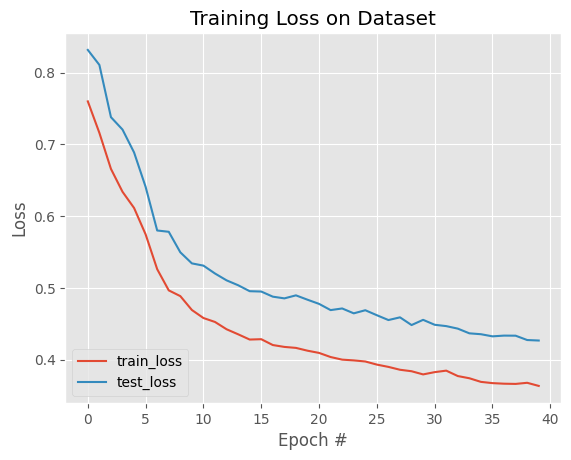

In [22]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH)
# serialize the model to disk
torch.save(unet, MODEL_PATH)

# Prediction

In [53]:
def make_predictions(model, imagePath):
	# set model to evaluation mode
	model.eval()
	# turn off gradient tracking
	with torch.no_grad():
		# load the image from disk, swap its color channels, cast it
		# to float data type, and scale its pixel values
		image = cv2.imread(imagePath)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		image = image.astype("float32") / 255.0
		# resize the image and make a copy of it for visualization
		image = cv2.resize(image, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT))
		orig = image.copy()
		# find the filename and generate the path to ground truth
		# mask
		filename = imagePath.split(os.path.sep)[-1]
		groundTruthPath = os.path.join(MASK_DATASET_PATH,
			filename)
		# load the ground-truth segmentation mask in grayscale mode
		# and resize it
		gtMask = cv2.imread(groundTruthPath)
		gtMask = cv2.resize(gtMask, (INPUT_IMAGE_WIDTH,
			INPUT_IMAGE_HEIGHT))
    	# make the channel axis to be the leading one, add a batch
		# dimension, create a PyTorch tensor, and flash it to the
		# current device
		image = np.transpose(image, (2, 0, 1))
		image = np.expand_dims(image, 0)
		image = torch.from_numpy(image).to(DEVICE)
		# make the prediction, pass the results through the sigmoid
		# function, and convert the result to a NumPy array
		predMask = model(image).squeeze()
		predMask = torch.sigmoid(predMask)
		predMask = predMask.cpu().numpy()
		# filter out the weak predictions and convert them to integers
		predMask = (predMask > THRESHOLD) * 255
		predMask = predMask.astype(np.uint8)
		# prepare a plot for visualization
		prepare_plot(orig, gtMask, predMask)

In [25]:
def prepare_plot(origImage, origMask, predMask):
	# initialize our figure
	predMask = np.transpose(predMask, (1, 2, 0))
	figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(30, 30))
	# plot the original image, its mask, and the predicted mask
	ax[0].imshow(origImage)
	ax[1].imshow(origMask)
	ax[2].imshow(predMask)
	# set the titles of the subplots
	ax[0].set_title("Image")
	ax[1].set_title("Original Mask")
	ax[2].set_title("Predicted Mask")
	# set the layout of the figure and display it
	figure.tight_layout()
	figure.show()

[INFO] loading up test image paths...
[INFO] load up model...


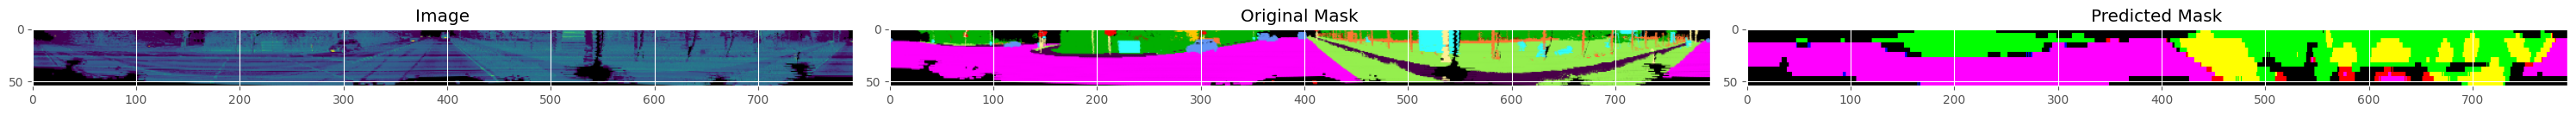

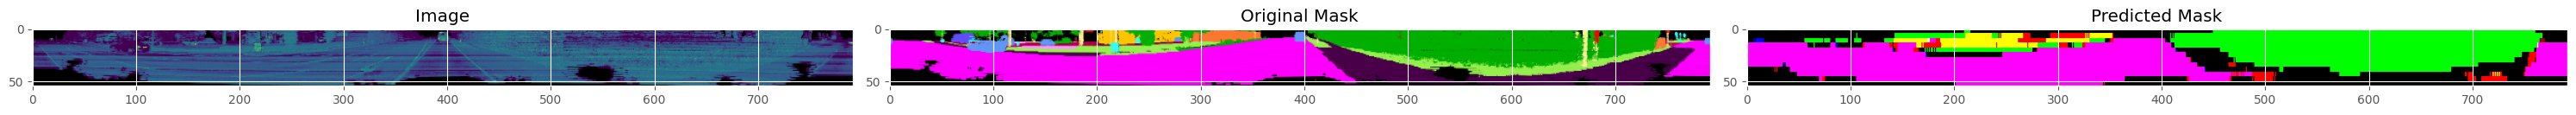

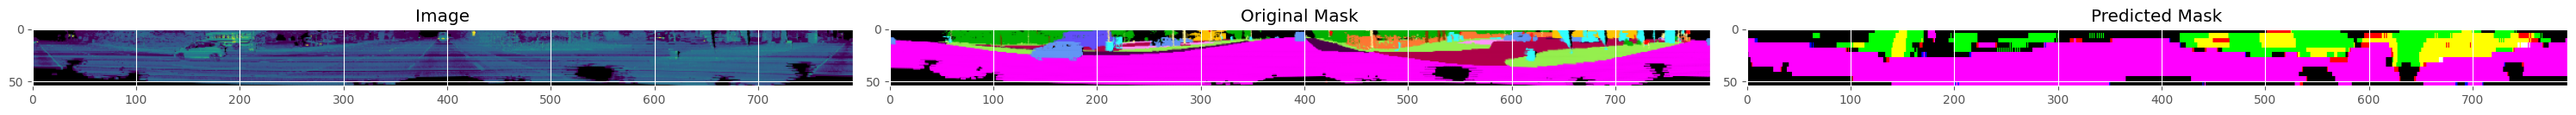

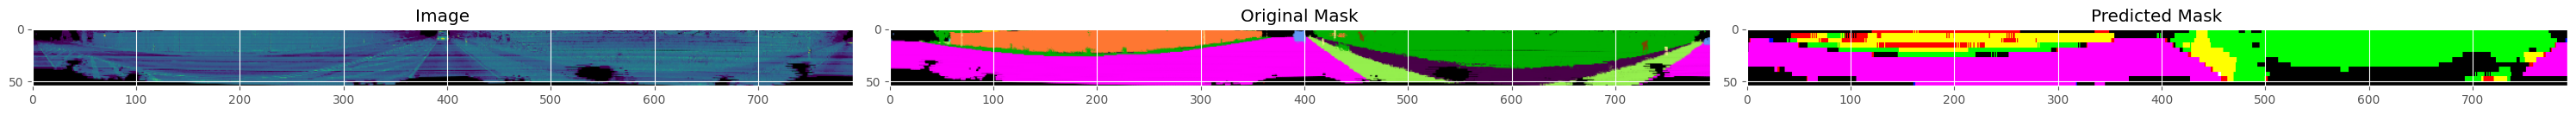

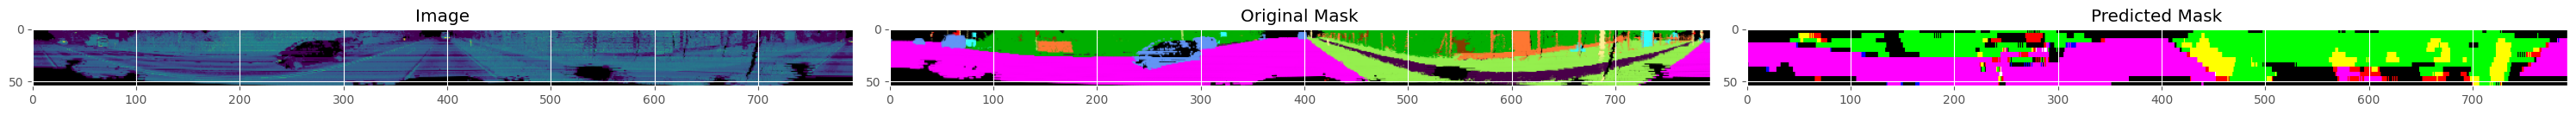

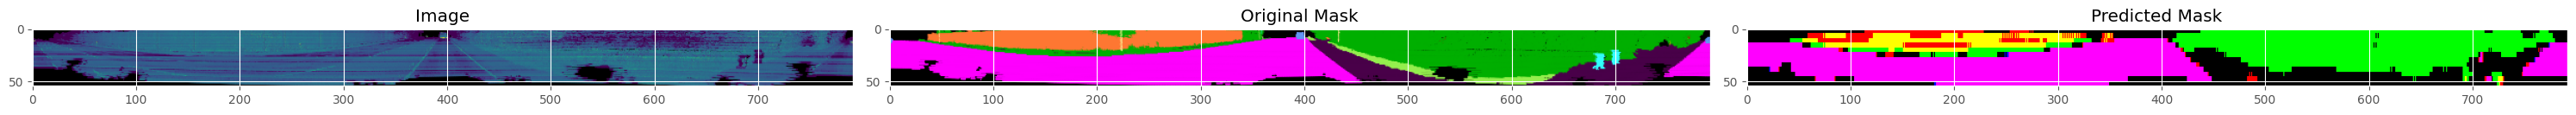

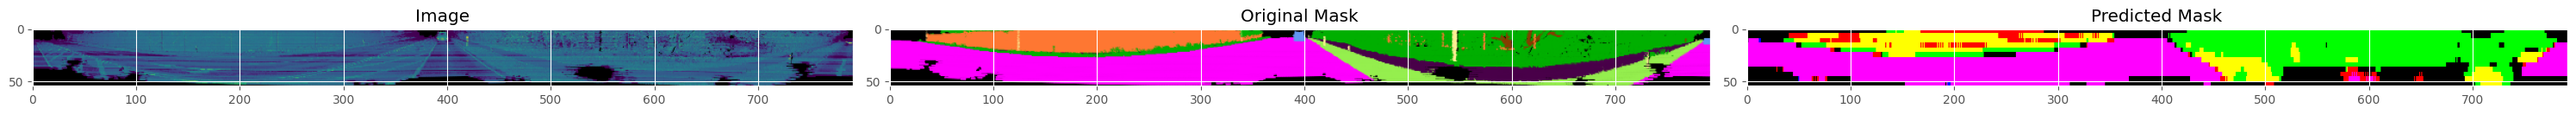

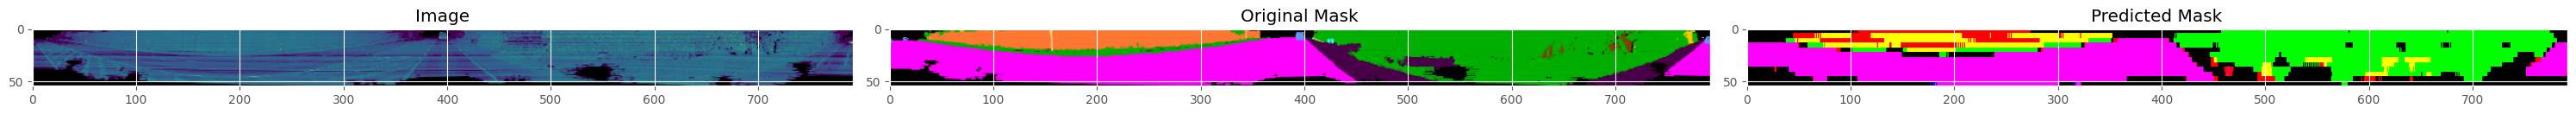

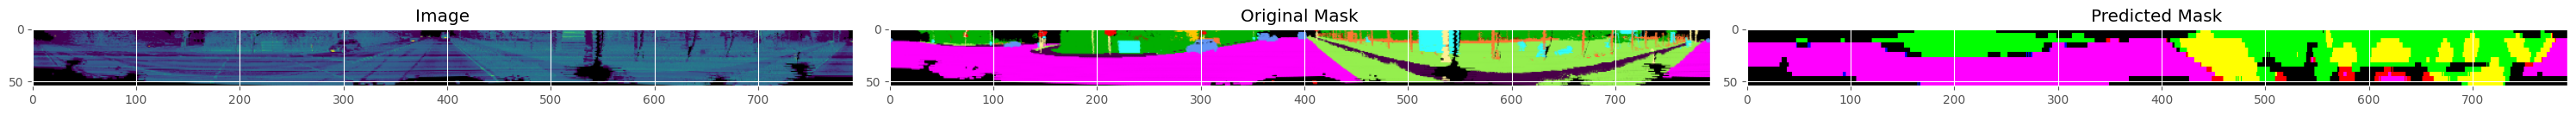

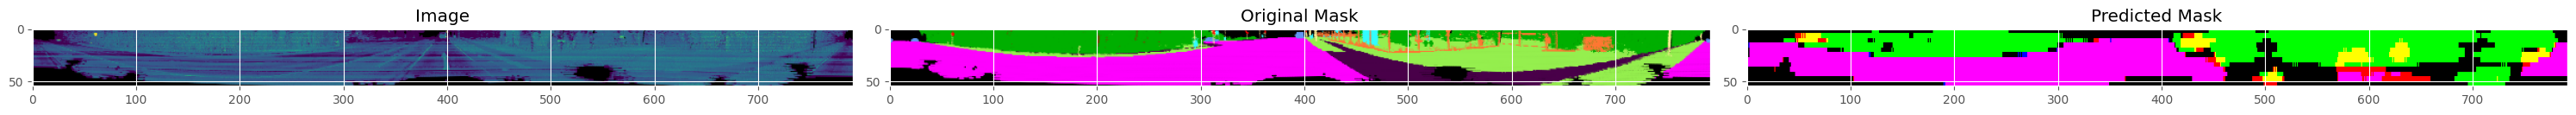

In [54]:
# load the image paths in our testing file and randomly select 10
# image paths
print("[INFO] loading up test image paths...")
imagePaths = open(TEST_PATHS).read().strip().split("\n")
imagePaths = np.random.choice(imagePaths, size=10)
# load our model from disk and flash it to the current device
print("[INFO] load up model...")
unet = torch.load(MODEL_PATH).to(DEVICE)
# iterate over the randomly selected test image paths
for path in imagePaths:
	# make predictions and visualize the results
	make_predictions(unet, path)